In [2]:
from xml.etree import ElementTree as ET
import pandas as pd
import folium
import json


def generate_coordinates_dictionary(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    tei_header = root.find('{http://www.tei-c.org/ns/1.0}teiHeader')
    if tei_header is not None:
        places = tei_header.findall('.//{http://www.tei-c.org/ns/1.0}place')
        coordinates_dict = {}

        for place in places:
            place_name_element = place.find(
                '{http://www.tei-c.org/ns/1.0}placeName')
            if place_name_element is not None:
                place_name = place_name_element.text
                
                place_type = place.get('type')

                geo_element = place.find(
                    '{http://www.tei-c.org/ns/1.0}location/{http://www.tei-c.org/ns/1.0}geo')
                if geo_element is not None:
                    coordinates = geo_element.text
                    if coordinates:
                        try:
                            lat, lon = coordinates.split(",")
                            # Convert to float and create a tuple
                            coordinates_dict[(place_name, place_type)] = (
                                float(lat), float(lon))
                            
                        except ValueError:
                            print(
                                f"Invalid coordinates format for {place_name}: {coordinates}")
                            

        m = folium.Map(location=[48.21095900638111,16.377296146797722], zoom_start=5)
        for key, value in coordinates_dict.items():
            if key[1] == 'city':
                folium.Circle(
                    radius=5000,
                    location=value,
                    popup=key[0],
                    color="#3186cc",
                    fill=True,
                    fill_color="#3186cc",
                    tooltip=key[0],
                ).add_to(m)
            else:
               folium.Marker(location=value, popup=key[0]).add_to(m)
        
        #modo per tracciare l'area dello stato
        try:
            with open('denmark-detailed-boundary_896.geojson', 'r', encoding='utf-8') as file:
                data = json.load(file)
                folium.GeoJson(data, name="denmark", tooltip="Denmark").add_to(m)
        except Exception as e:
            print(f"Error loading GeoJSON: {e}")

        return m
        
# m.save("metascript_map.html")


generate_coordinates_dictionary("C:/Users/crosi/Documents/GitHub/metascript/Dream_Story.xml")

In [1]:
from xml.etree import ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import csv

def generate_coordinates_dictionary(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    content_list = []
    for said_tag in root.findall('.//{http://www.tei-c.org/ns/1.0}said'):
        who_tag = said_tag.get('who')
        listener_tag = said_tag.get('toWhom')
        if who_tag is not None:
            content_list.append((who_tag,listener_tag))

    interactions={}
    for i in content_list:
        if i not in interactions:
            interactions[i] = 1
        else:
            interactions[i] +=1
    
        # Write interactions to a CSV file
    with open('interactions.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        # Write header
        csvwriter.writerow(['Character', 'Listener', 'Interaction Count'])
        
        # Write data rows
        for (who, listener), count in interactions.items():
            listener_str = listener if listener else "unknown"
            csvwriter.writerow([who, listener_str, count])

    print("CSV file 'interactions.csv' created.")

generate_coordinates_dictionary("C:/Users/crosi/Documents/GitHub/metascript/Dream_Story.xml")

CSV file 'interactions.csv' created.


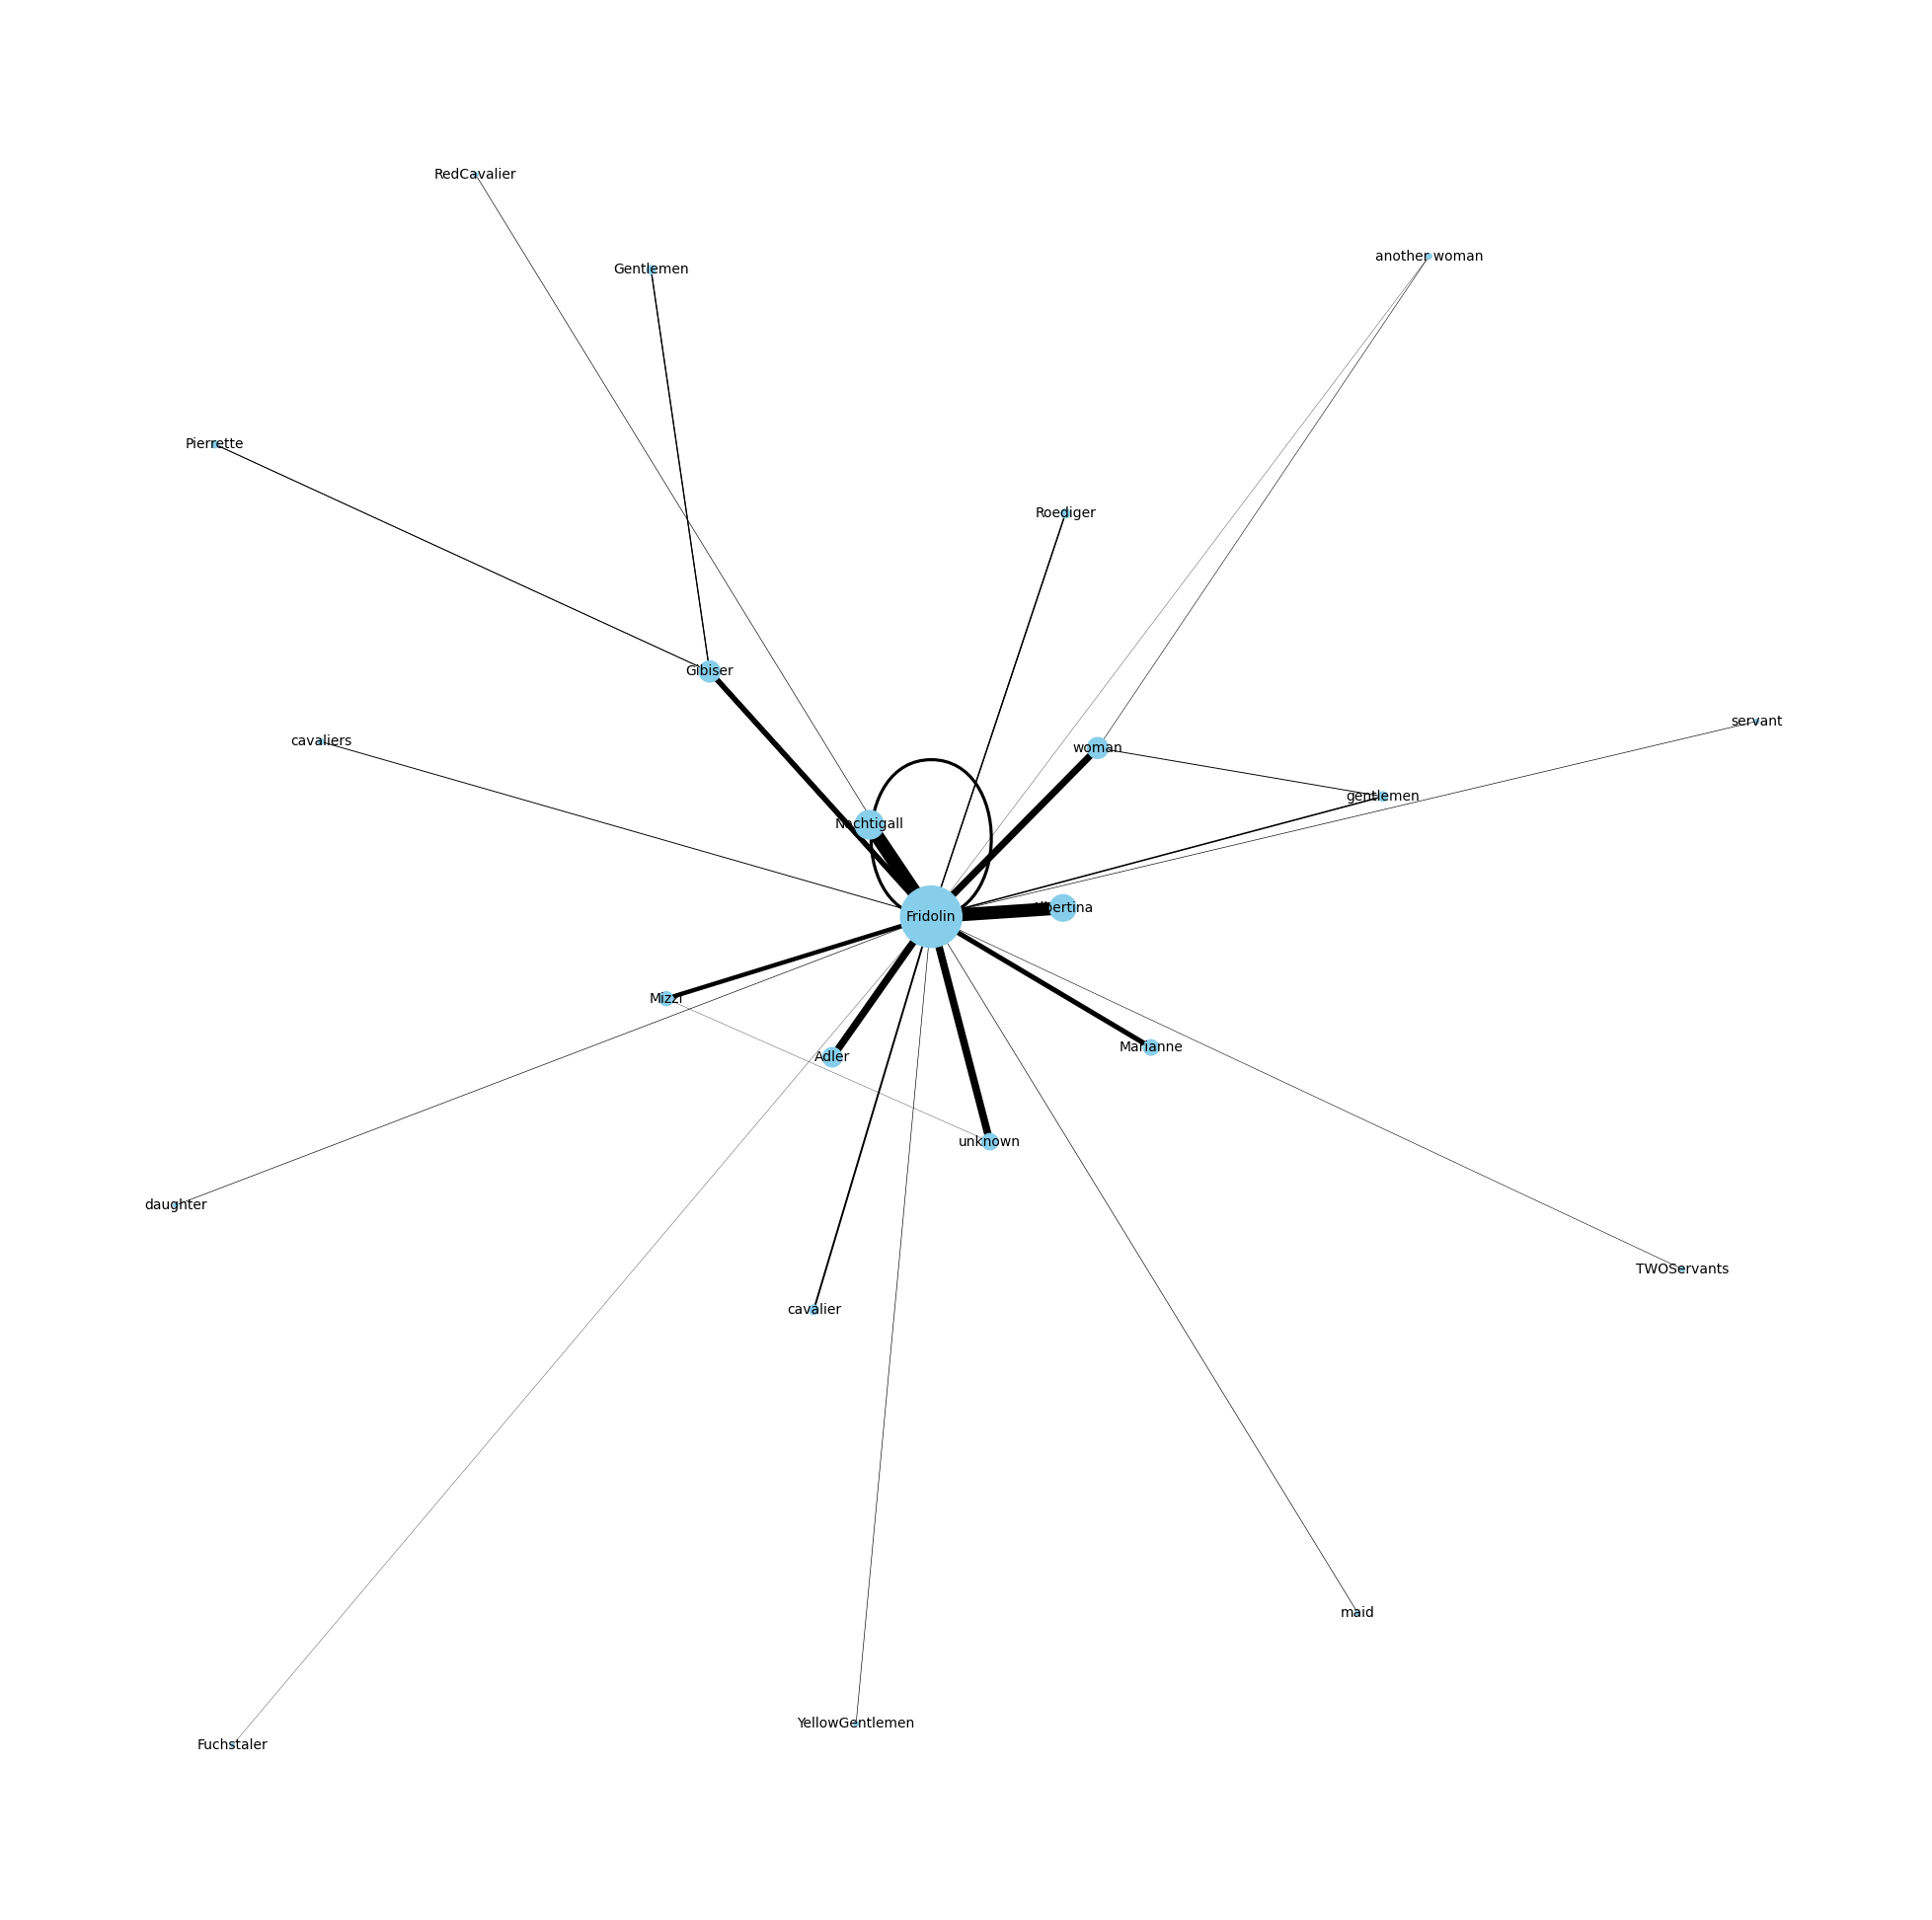

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv

# Read CSV data
df = pd.read_csv('interactions.csv')

# Create a graph
G = nx.MultiGraph()

# Add nodes and edges
for index, row in df.iterrows():
    source = row['Character']
    target = row['Listener']
    interactions = row['Interaction Count']  # Assuming 'interactions' is the column with interaction counts
    G.add_edge(source, target, weight=interactions)

# Create a layout for our nodes
pos = nx.spring_layout(G)

# Get edge weights as a list
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Normalize edge weights for visualization thickness
edge_weights_normalized = [float(w) / max(edge_weights) * 10 for w in edge_weights]

# Calculate total interaction weight for each character
total_weights = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}

# Determine the maximum total weight for scaling
max_total_weight = max(total_weights.values())

# Calculate node sizes based on total weights
node_sizes = [total_weights[node] / max_total_weight * 2000 for node in G.nodes()]

# Create a new figure and separate nodes and edges plots
plt.figure(figsize=(25, 25))

# Draw nodes with proportional sizes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

# Draw edges with varying thickness
nx.draw_networkx_edges(G, pos, width=edge_weights_normalized)

# Draw labels for nodes
nx.draw_networkx_labels(G, pos, font_size=10)

# Show the plot
plt.axis('off')
plt.show()


